# Event Driven MD

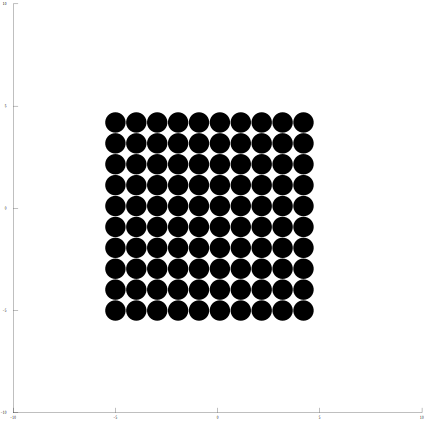

In [58]:
using Plots

N = 100
box_length = 20
r = 0.5
xpos = zeros(N)
ypos = zeros(N)
xvel = zeros(N)
yvel = zeros(N)

function initialize!(xpos,ypos,xvel,yvel,N,box_length,r)
    for i in 1:10
        for j in 1:10
            xpos[j + 10*(i-1)] = -0.25*box_length + (j-1)*2*(r + (0.1/9.0))
            ypos[j + 10*(i-1)] = -0.25*box_length + (i-1)*2*(r + (0.1/9.0))
            xvel[j + 10*(i-1)] = (1 - 2*rand())*0.001
            yvel[j + 10*(i-1)] = -(1 - 2*(i%2)) + (1 - 2*rand())*0.001
        end
    end
end

function circle(x, y, r=0.5; n=30)
    θ = 0:360÷n:360
    Plots.Shape(r*sind.(θ) .+ x, r*cosd.(θ) .+ y)
end

initialize!(xpos,ypos,xvel,yvel,N,box_length,r)
circles = circle.(xpos,ypos)

plot_kwargs = (aspect_ratio=:equal, fontfamily="Helvetica", legend=false, line=nothing,color=:black, grid=false, xlim=(-10,10), ylim=(-10,10))

plot(circles; plot_kwargs...,size = (1700, 1700))


In [14]:
function first_collision(xpos,ypos,xvel,yvel,box_length)
    t = Float64[]
    num::Int64 = 0
    d1 = 0
    d2 = 0
    for i in 1:N-1
        for j in i+1:N
            rx = xpos[j] - xpos[i]
            ry = ypos[j] - ypos[i]
            vx = xvel[j] - xvel[i]
            vy = yvel[j] - yvel[i]
            rx = rx - box_length*round(rx/box_length)
            ry = ry - box_length*round(ry/box_length)
            b = rx*vx + ry*vy
            v2 = vx^2 + vy^2
            r2 = rx^2 + ry^2
            if b<0.0
                c = b^2 - v2*(r2 - 1)
                if c>=0
                    push!(t,(-b - sqrt(c))/v2)
                    push!(t,i)
                    push!(t,j)
                    num = num+1
                end
            end
        end
    end
    for i in 1:N
        if xvel[i]>0.0
            tx = (0.5*box_length - xpos[i])/xvel[i]
        else
            tx = (-0.5*box_length - xpos[i])/xvel[i]
        end
        if yvel[i]>0.0
            ty = (0.5*box_length - ypos[i])/yvel[i]
        else
            ty = (-0.5*box_length - ypos[i])/yvel[i]
        end
        if tx<ty
            push!(t,tx)
            push!(t,i)
            push!(t,101)
        else
            push!(t,ty)
            push!(t,i)
            push!(t,102)
        end
        num = num + 1
    end
    pushfirst!(t,num)
    tmin = t[2]
    #println(t)
    #d1 = 1
    #d2 = 1
    for i in 1:Int(t[1])
        if t[3*(i-1) + 1 + 1] <= tmin
            tmin = t[3*(i-1) + 1 + 1]
            d1 = t[3*(i-1) + 2 + 1]
            d2 = t[3*(i-1) + 3 + 1]
        end
    end
    return tmin,Int(d1),Int(d2)
end

#println(first_collision(xpos,ypos,xvel,yvel,box_length))

first_collision (generic function with 1 method)

In [15]:
function advance!(xpos,ypos,xvel,yvel,box_length,t,d1,d2)
    for i in 1:N
        xpos[i] = xpos[i] + t*xvel[i]
        ypos[i] = ypos[i] + t*yvel[i]
        #xpos[i] = xpos[i] - box_length*round(xpos[i]/box_length)
        #ypos[i] = ypos[i] - box_length*round(ypos[i]/box_length)
    end
    if d2<=100
        rx = xpos[d2] - xpos[d1]
        ry = ypos[d2] - ypos[d1]
        rx = rx - box_length*round(rx/box_length)
        ry = ry - box_length*round(ry/box_length)
        b = rx*(xvel[d2] - xvel[d1]) + ry*(yvel[d2] - yvel[d1])
        xvel[d1] = xvel[d1] + b*rx
        yvel[d1] = yvel[d1] + b*ry
        xvel[d2] = xvel[d2] - b*rx
        yvel[d2] = yvel[d2] - b*ry
    elseif d2==101
        xpos[d1] = -xpos[d1]
    elseif d2==102
        ypos[d1] = -ypos[d1]
    end
end

advance! (generic function with 1 method)

In [62]:
using DelimitedFiles
function edmd!(xpos,ypos,xvel,yvel,ncoll)
    initialize!(xpos,ypos,xvel,yvel,N,box_length,r)
    ke = zeros(ncoll)
    v = zeros(100)
    t_elapsed = zeros(ncoll)
    t_elapsed[1] = 0.0
    for j in 1:100
        ke[1] = 0.5*(xvel[j]^2 + yvel[j]^2)
        #v[j] = v[j] + sqrt(xvel[j]^2 + yvel[j]^2)
    end    
    T = ke[1]/100

    for i in 2:ncoll
        t,d1,d2 = first_collision(xpos,ypos,xvel,yvel,box_length)
        t_elapsed[i] = t_elapsed[i-1] + t
        for j in 1:100
            ke[i] = ke[i] + 0.5*(xvel[j]^2 + yvel[j]^2)
        end
        advance!(xpos,ypos,xvel,yvel,box_length,t,d1,d2)
        if i%1000 == 0
            v = zeros(100)
            for j in 1:100
                v[j] = sqrt(xvel[j]^2 + yvel[j]^2)
            end
            #v .= v./1000
            open("data_p1/histo_v_$i","w") do io
                writedlm(io,v)
            end
        end
    end
    open("data_p1/ke","w") do io
        writedlm(io,[t_elapsed,ke])
    end
    return T
end
T = edmd!(xpos,ypos,xvel,yvel,100000)

0.005005562602840758

┌ Info: Saved animation to 
│   fn = /home/pushkar/comp-phys/a2/hist.gif
└ @ Plots /home/pushkar/.julia/packages/Plots/iYDwd/src/animation.jl:104


Plots.AnimatedGif("/home/pushkar/comp-phys/a2/hist.gif")
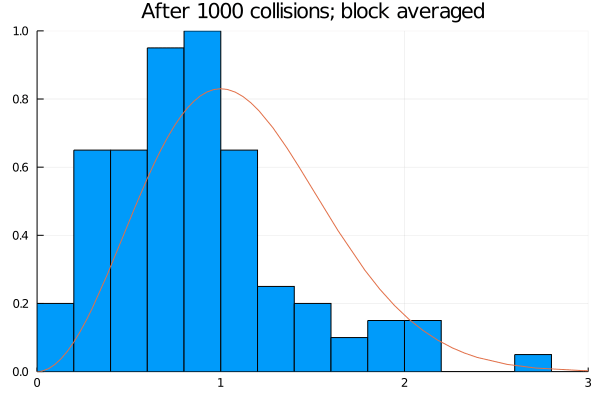

In [66]:
using Distributions, DelimitedFiles
using Plots
gr()

T = 0.5
mb(x,a) = ((1/(2*pi*a))^1.5)*(4*pi)*(x^2)*exp(-(x^2)/(2*a))
anim = @animate for k in 1:100
    #x = 0.25:0.01:1.5
    i = k*1000
    v = readdlm("data_p1/histo_v_$i")
    histogram(v,nbins=20,title="After $i collisions; block averaged",legend=false,normalize=true,xlim=(0,3.0),ylim=(0,1))
    plot!(x->mb(x,T),xlim=xlims())
end
gif(anim,"hist.gif",fps=4)